In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import itertools
import os
import sys
from functools import partial
from itertools import chain
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import pymcr
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from pymcr.mcr import McrAR
from pymcr.regressors import LinearRegression
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from torchtyping import TensorType
import torchinfo


print("Python version: ", sys.version)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("pymcr version: ", pymcr.__version__)
print("torch version", torch.__version__)

Python version:  3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
numpy version:  2.1.3
matplotlib version:  3.9.2
pymcr version:  0.5.1
torch version 2.5.1


/Users/brandonsaint-john/src/pymcr-torch-demo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
random.seed(717)
np.random.seed(717)
torch.manual_seed(717)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, z_dim: int):
        super().__init__()

        self.fc_mean = nn.Linear(in_features=hidden_size, out_features=z_dim)
        self.fc_std = nn.Linear(in_features=hidden_size, out_features=z_dim)

        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x: TensorType["batch", "input_size"]):
        x = self.relu(self.fc1(x))
        z_loc = self.fc_mean(x)
        z_scale = torch.exp(self.fc_std(x))

        return z_loc, z_scale


torchinfo.summary(
    Encoder(input_size=2301, hidden_size=256, z_dim=64), (1, 2301)
)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 64]                   --
├─Linear: 1-1                            [1, 256]                  589,312
├─ReLU: 1-2                              [1, 256]                  --
├─Linear: 1-3                            [1, 64]                   16,448
├─Linear: 1-4                            [1, 64]                   16,448
Total params: 622,208
Trainable params: 622,208
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.62
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.49
Estimated Total Size (MB): 2.50

In [5]:
class Decoder(nn.Module):
    def __init__(self, output_size: int, hidden_size: int, z_dim: int):
        super().__init__()

        self.fc_mean_std = nn.Linear(in_features=z_dim, out_features=hidden_size)

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, z: TensorType["batch", "z_dim"]):
        hidden = self.relu(self.fc_mean_std(z))
        loc_out = self.fc1(hidden)

        return loc_out


torchinfo.summary(Decoder(output_size=2301, hidden_size=256, z_dim=64), (1, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 2301]                 --
├─Linear: 1-1                            [1, 256]                  16,640
├─ReLU: 1-2                              [1, 256]                  --
├─Linear: 1-3                            [1, 2301]                 591,357
Total params: 607,997
Trainable params: 607,997
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.61
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.43
Estimated Total Size (MB): 2.45

In [6]:
class VAE(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        z_dim: int,
        use_gpu: bool = False,
    ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        self.use_gpu = use_gpu

        self.encoder = Encoder(
            input_size=input_size, hidden_size=hidden_size, z_dim=self.z_dim
        )
        self.decoder = Decoder(
            output_size=input_size, hidden_size=hidden_size, z_dim=self.z_dim
        )

        if use_gpu:
            if torch.backends.mps.is_available():
                torch.set_default_device("mps")
            elif torch.cuda.is_available():
                torch.set_default_device("cuda")
            else:
                print("GPU is not available")


    def model(self, A, B):
        pyro.module("encoder", self.encoder)
        pyro.module("decoder", self.decoder)

        x = pyro.sample(
            "x",
            dist.Normal(
                torch.zeros(A.shape[1], B.shape[1]), torch.ones(B.shape[1])
            ).to_event(2),
        )
        z_loc, z_scale = self.encoder(x)

        # Sample values according the latent vector
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(2))

        loc_out = pyro.deterministic("x_recon", self.decoder(z))
        Axb = pyro.deterministic("A @ x_recon", torch.matmul(A, loc_out))
        sigma = pyro.sample("sigma", dist.Uniform(1.0, 10.0))
        pyro.sample(
            "B",
            dist.Normal(loc=Axb, scale=sigma, validate_args=True).to_event(2),
            obs=B,
        )

        return loc_out

    def reconstruct_spectra(self, X):
        z_loc, z_scale = self.encoder(X)
        z = dist.Normal(z_loc, z_scale).sample()
        loc = self.decoder(z)

        return loc


In [ ]:
pyro.render_model(
    VAE(input_size=2301, hidden_size=256, z_dim=64).model,
    model_args=(torch.ones(55, 2), torch.ones(55, 2301)),
    render_deterministic=True,
    render_distributions=True,
)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [8]:
class McrVae(LinearRegression):
    """The pyMCR regressor using variational autoencoders for performing multivariate curve resolution - alternating regression."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        z_dim: int,
        learning_rate: float = 1e-4,
    ):
        super().__init__()
        pyro.clear_param_store()
        self.vae = VAE(
            input_size=input_size, hidden_size=hidden_size, z_dim=z_dim
        )
        self.optimizer = pyro.optim.Adam(optim_args={"lr": learning_rate})
        self.guide = AutoDiagonalNormal(self.vae.model)
        self.svi = pyro.infer.SVI(
            model=self.vae.model,
            guide=self.guide,
            optim=self.optimizer,
            loss=pyro.infer.Trace_ELBO(),
        )

    def fit(self, A: NDArray, B: NDArray):
        """ "
        Solve Ax=B using Variational Autoencoders using Pyro. A and B are numpy arrays, so must be converted to pytorch Tensors.

        Once X is solved for the result needs to be converted back into numpy arrays and stored in self.X_
        """
        A = torch.from_numpy(A.astype(np.float32))
        B = torch.from_numpy(B.astype(np.float32))

        epoch_loss = 0
        for _ in range(1000):
            loss = self.svi.step(A, B)
            epoch_loss += loss

        print("epoch loss", epoch_loss)
        print("A, B shape = ", A.shape, B.shape)
        guide_dict = self.guide(A, B)
        latent = guide_dict["latent"]
        x = self.vae.decoder(latent)
        self.X_ = x.detach().numpy().astype(np.float64)


In [9]:
class TorchLeastSquares(LinearRegression):
    """
    Simple example class using pytorch to create a model compatible with pyMCR.

    This inherits from the LinearRegression abstract base class. and needs to implement the
    fit abstract method that takes two arguments A and B. The fit method should store the result
    from solving Ax=B into self.X_.
    """

    def __init__(self, *args, **kwargs):
        super().__init__()
        self.rank = None
        self.sv = None

    def fit(self, A: NDArray, B: NDArray):
        """ "
        Solve Ax=B using pytorch least squares. A and B are numpy arrays, so must be converted to pytorch Tensors.

        Once X is solved for the result needs to be converted back into numpy arrays and stored in self.X_
        """
        A = torch.from_numpy(A)
        B = torch.from_numpy(B)

        X_, residuals, self.rank, self.sv = torch.linalg.lstsq(A, B)

        self.X_ = X_.numpy()
        self.residuals = residuals.numpy()

In [11]:
with open("../data/ethanol/ethanol-mcr.npz", "rb") as ethanol_mcr_file:
    ethanol_mcr = np.load(ethanol_mcr_file)

    D = ethanol_mcr["D"]
    C = ethanol_mcr["C"]
    St = ethanol_mcr["ST"]
    wavelengths = ethanol_mcr["wavelengths"]

    N_SAMPLES = D.shape[0]
    N_WAVELENGTHS = D.shape[1]
    N_COMPONENTS = C.shape[1]

    print(ethanol_mcr)

NpzFile 'object' with keys: D, C, ST, wavelengths


In [13]:
print(
    f"D shape (samples x wavelengths): {D.shape}\n"
    f"C shape (samples x components): {C.shape}\n"
    f"ST shape (components x wavelengths): {St.shape}\n"
    f"wavelengths shape: {wavelengths.shape}"
)

D shape (samples x wavelengths): (55, 2301)
C shape (samples x components): (55, 2)
ST shape (components x wavelengths): (2, 2301)
wavelengths shape: (2301,)


## Predicting Concentrations from Pure Spectra

The fit errors due to the mean-squared error increasing above the tolerance. From what I understand, this means it finds the optimal value very quickly.

In [15]:
mcrar_conc = McrAR(
    max_iter=100,
    st_regr=McrVae(input_size=N_WAVELENGTHS, hidden_size=256, z_dim=64),
    c_regr="OLS",
    c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=1.0,
)
mcrar_conc.fit(D=D, ST=St, verbose=True)

Iter: 1 (C)	mse: 2.9061e-04


epoch loss 329725787.12931645
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 1 (ST)	mse: 4.2669e-04
Iter: 2 (C)	mse: 4.1731e-04
epoch loss 323233597.3717027
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 2 (ST)	mse: 4.3297e-04
Iter: 3 (C)	mse: 4.3361e-04
epoch loss 317407611.6974708
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 3 (ST)	mse: 3.4575e-04
Iter: 4 (C)	mse: 3.2466e-04
epoch loss 310259848.39409363
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 4 (ST)	mse: 2.9882e-04
Iter: 5 (C)	mse: 3.0030e-04
epoch loss 304010064.37563574
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 5 (ST)	mse: 2.6985e-04
Iter: 6 (C)	mse: 2.6876e-04
epoch loss 296457833.4175917
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 6 (ST)	mse: 2.3765e-04
Iter: 7 (C)	mse: 2.4361e-04
epoch loss 290101402.02739227
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 7 (ST)	mse: 2.1226e-04
Iter: 8 (C)	mse: 2.1581

In [12]:
def plot_mcrar_concentrations(mcr_obj: McrAR):
    fig, ax = plt.subplots(1, 1)
    mcr_obj.fit(D=D, ST=St, verbose=True)
    ax.scatter(x=C[:, 0], y=mcr_obj.C_opt_[:, 1], s=10, alpha=0.5)
    plt.ylabel("Predictions from MCR-ALS")
    plt.xlabel("Ground Truth Ethanol Percentages")
    plt.title("MCR-ALS Predictions based on Pure Spectra")
    return fig, ax


def plot_mcrar_spectra(mcr_obj, ax = None):
    mcr_obj.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)
    vis_cols = [
        float(col.split("_")[1]) for col in wavelengths if "avaspec" in col
    ]
    nir_cols = [
        float(col.split("_")[1]) for col in wavelengths if "hamamatsu" in col
    ]

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

    ax[0].plot(
        vis_cols,
        mcr_obj.ST_[0, :2048],
        alpha=0.4,
    )
    ax[0].plot(
        vis_cols,
        mcr_obj.ST_[1, :2048],
        alpha=0.4,
    )

    ax[1].plot(
        nir_cols,
        mcr_obj.ST_[0, 2048:],
        alpha=0.4,
    )
    ax[1].plot(
        nir_cols,
        mcr_obj.ST_[1, 2048:],
        alpha=0.4,
    )

    ax[1].set_title("NIR Predicted Pure Spectra")
    ax[0].set_title("Visible Predicted Pure Spectra")
    ax[0].set_ylabel("Predicted Absorbance")
    ax[0].set_xlabel("Wavelength (nm)")
    ax[1].set_xlabel("Wavelength (nm)")
    return fig, ax

Text(0.5, 1.0, 'MCR-ALS Predictions based on Pure Spectra')

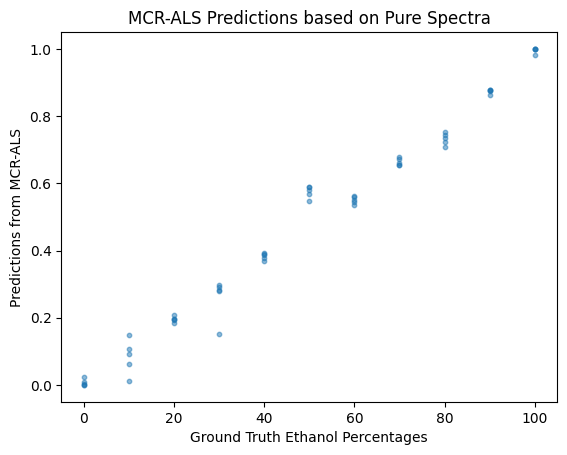

In [13]:
# I think its random whjch axis in C_opt_ gets which concentration
plt.scatter(x=C[:, 0], y=mcrar.C_opt_[:, 1], s=10, alpha=0.5)
plt.ylabel("Predictions from MCR-ALS")
plt.xlabel("Ground Truth Ethanol Percentages")
plt.title("MCR-ALS Predictions based on Pure Spectra")

## Predicting Pure Spectra from Concentration data

In this example I leave out the pure water and ethanol spectra that we already know. In the data matrix, these are the first 5 and last 5 samples. The 

In [ ]:
mcrar_spec = McrAR(
    max_iter=100,
    st_regr=McrVae(input_size=N_WAVELENGTHS, hidden_size=256, z_dim=64),
    c_regr="OLS",
    # c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
)
mcrar_spec.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

epoch loss 279594685.4112289
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 1 (ST)	mse: 7.0194e-04
Iter: 2 (C)	mse: 3.6449e-04
epoch loss 274537576.636384
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 2 (ST)	mse: 3.3251e-04
Iter: 3 (C)	mse: 3.2683e-04
epoch loss 269431195.29194915
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 3 (ST)	mse: 3.6270e-04
Iter: 4 (C)	mse: 3.3519e-04
epoch loss 264617945.73451602
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 4 (ST)	mse: 2.6090e-04
Iter: 5 (C)	mse: 2.5569e-04
epoch loss 258999615.6447971
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 5 (ST)	mse: 2.5035e-04
Iter: 6 (C)	mse: 2.3900e-04
epoch loss 253602456.1795087
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 6 (ST)	mse: 2.2584e-04
Iter: 7 (C)	mse: 2.0062e-04
epoch loss 248135410.49681628
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 7 (ST)	mse: 2.2442e-04
Iter: 8 (C)	mse: 1.9608e-

Text(0.5, 0, 'Wavelength (nm)')

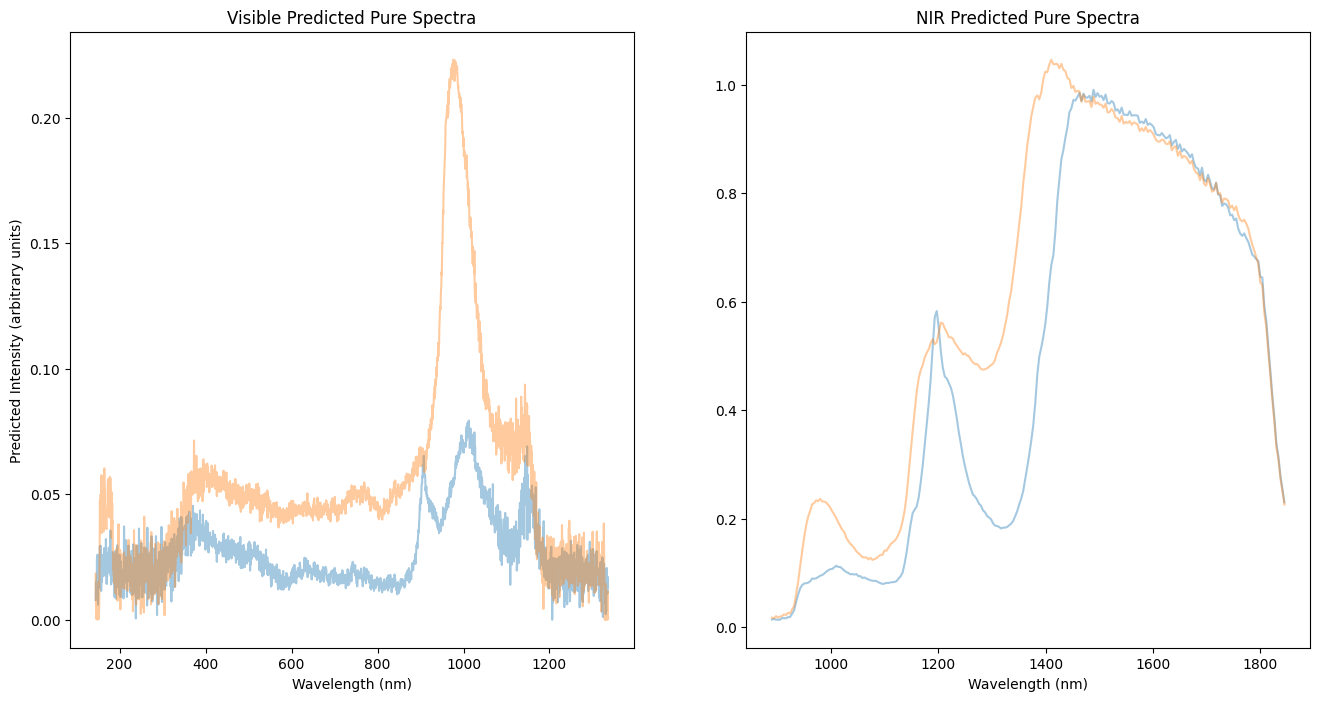

In [ ]:
vis_cols = [
    float(col.split("_")[1]) for col in wavelengths if "avaspec" in col
]
nir_cols = [
    float(col.split("_")[1]) for col in wavelengths if "hamamatsu" in col
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].plot(
    vis_cols,
    mcrar_spec.ST_[0, :2048],
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    mcrar_spec.ST_[1, :2048],
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    mcrar_spec.ST_[0, 2048:],
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    mcrar_spec.ST_[1, 2048:],
    alpha=0.4,
)

ax[1].set_title("NIR Predicted Pure Spectra")
ax[0].set_title("Visible Predicted Pure Spectra")
ax[0].set_ylabel("Predicted Intensity (arbitrary units)")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")

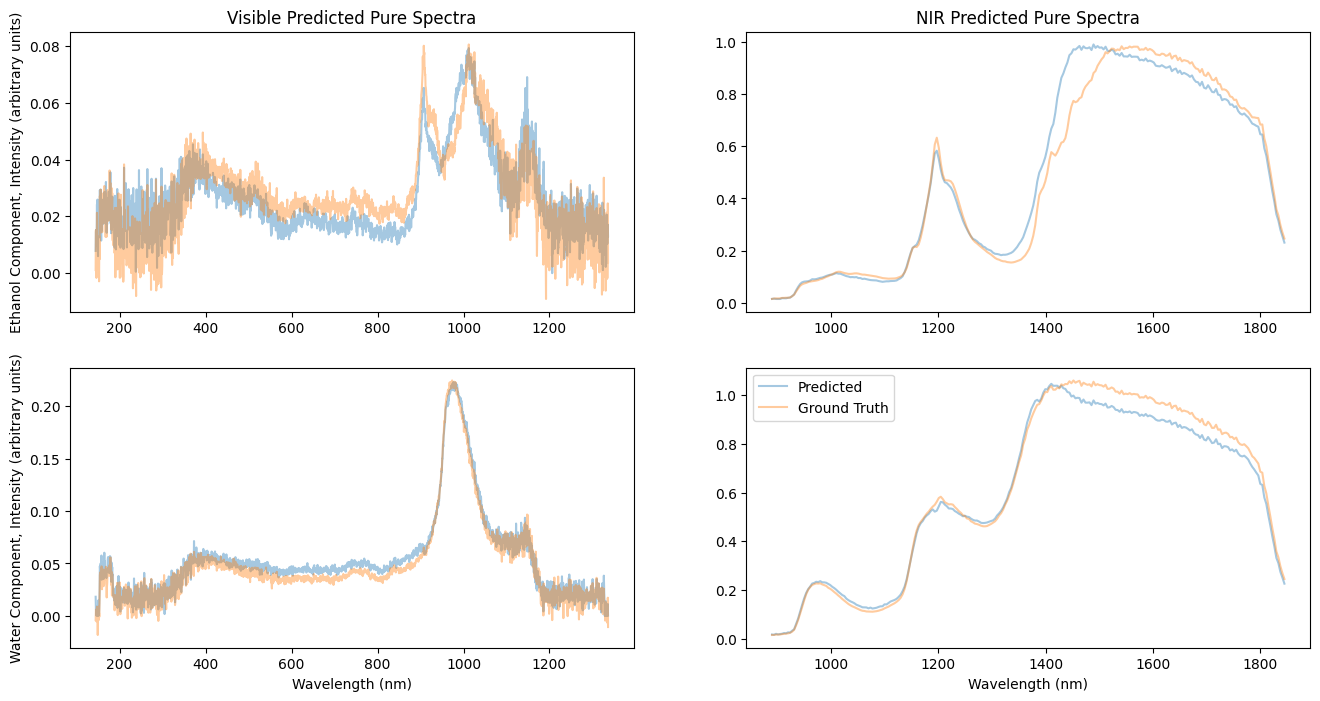

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

ax[0, 0].plot(
    vis_cols,
    mcrar_spec.ST_[0, :2048],
    alpha=0.4,
)
ax[0, 0].plot(
    vis_cols,
    St[1, :2048],
    alpha=0.4,
    
)
ax[1, 0].plot(
    vis_cols,
    mcrar_spec.ST_[1, :2048],
    alpha=0.4,
)
ax[1, 0].plot(
    vis_cols,
    St[0, :2048],
    alpha=0.4,
    
)

ax[0, 1].plot(
    nir_cols,
    mcrar_spec.ST_[0, 2048:],
    alpha=0.4,
    label="Prediction"
)
ax[0, 1].plot(
    nir_cols,
    St[1, 2048:],
    alpha=0.4,
    label="Ground Truth"
)

ax[1, 1].plot(
    nir_cols,
    mcrar_spec.ST_[1, 2048:],
    alpha=0.4,
    label="Predicted",
)
ax[1, 1].plot(
    nir_cols,
    St[0, 2048:],
    alpha=0.4,
    label="Ground Truth",
)

ax[0, 1].set_title("NIR Predicted Pure Spectra")
ax[0, 0].set_title("Visible Predicted Pure Spectra")
ax[0, 0].set_ylabel("Ethanol Component, Intensity (arbitrary units)")
ax[1, 0].set_ylabel("Water Component, Intensity (arbitrary units)")
ax[-1, 0].set_xlabel("Wavelength (nm)")
ax[-1, 1].set_xlabel("Wavelength (nm)")
ax[-1, -1].legend()

(2, 2301)
(55, 2301)


Text(0.5, 0.98, 'Sampling latent variables of pure spectra')

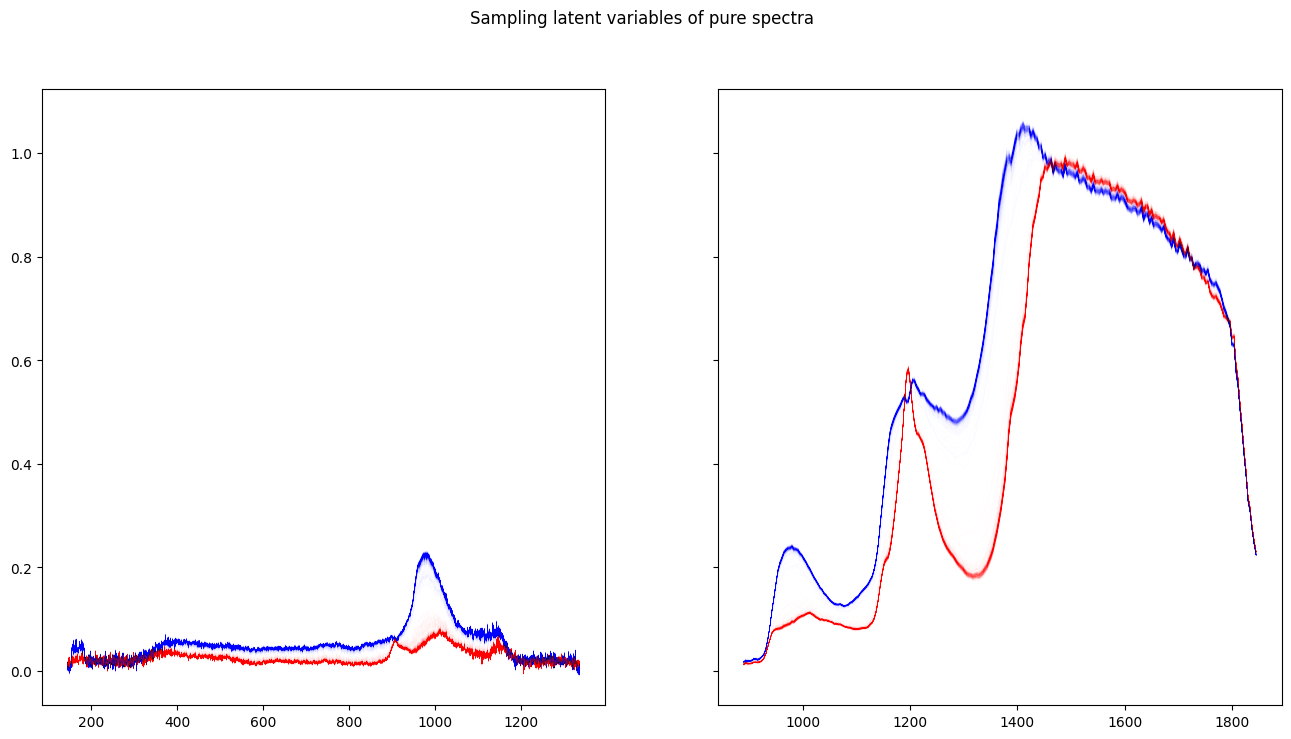

In [ ]:
plot_params = {
    "alpha": 0.05,
    "lw": 0.1,
}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
print(St.shape)
print(D.shape)
for _ in range(500):
# D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True
    z = mcrar_spec.st_regressor.guide(C[5:-5, :], D[5:-5, :])
    spectra = mcrar_spec.st_regressor.vae.decoder(z["latent"])
    spectra = spectra.detach().numpy()
    ax[0].plot(
        vis_cols,
        spectra[1, :2048],
        c="blue",
        **plot_params
    )
    ax[0].plot(
        vis_cols,
        spectra[0, :2048],
        c="red",
        **plot_params
    )
    # plot_params["alpha"] = min(1.0, plot_params["alpha"] *  2)
    # plot_params["lw"] *= 2
    ax[1].plot(
        nir_cols,
        spectra[1, 2048:],
        c="blue",
        **plot_params
    )
    ax[1].plot(
        nir_cols,
        spectra[0, 2048:],
        c="red",
        **plot_params
    )
fig.suptitle("Sampling latent variables of pure spectra")

In [ ]:
from pyro.infer import Predictive

num_samples = 100
predictive = Predictive(
    model=mcrar_spec.st_regressor.vae.model, guide=mcrar_spec.st_regressor.guide, num_samples=num_samples
)
pred = predictive(torch.from_numpy(C[5:-5, :]).float(), torch.from_numpy(D[5:-5, :]).float())
pred
# mcrar.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

{'x': tensor([[[ 0.4734,  0.3570,  0.4417,  ...,  1.0178,  1.2590, -0.4005],
          [-0.3323, -0.5708,  1.0249,  ..., -1.1742, -0.1030,  0.1337]],
 
         [[-0.2536,  0.1631,  0.0616,  ..., -1.1697,  0.3967,  0.3180],
          [-0.4883,  0.0533, -0.7488,  ...,  0.2405, -1.6171, -0.1231]],
 
         [[ 1.9958, -1.5429,  0.8057,  ..., -0.8409, -0.1678,  1.1250],
          [ 0.8300, -1.0515,  1.1652,  ...,  0.2280, -0.5569,  1.1624]],
 
         ...,
 
         [[-0.2813,  1.2408, -0.2259,  ..., -0.8196,  0.4998, -1.5529],
          [ 1.1119, -1.8091, -0.7244,  ..., -0.7719,  1.0219,  0.4773]],
 
         [[ 0.7667, -0.1228,  1.7151,  ...,  0.1002,  1.2671, -0.5287],
          [ 0.2489, -0.9545, -0.5797,  ...,  0.7160,  1.2071,  1.4006]],
 
         [[ 0.8333,  0.5788, -0.9975,  ..., -2.3675,  0.1276, -0.6396],
          [-0.9021, -1.8607, -1.4878,  ...,  0.1419, -0.0421, -1.9864]]]),
 'latent': tensor([[[ 0.2426,  0.0703,  0.0264,  ...,  0.0851,  0.2545, -0.1744],
          [ 0.3

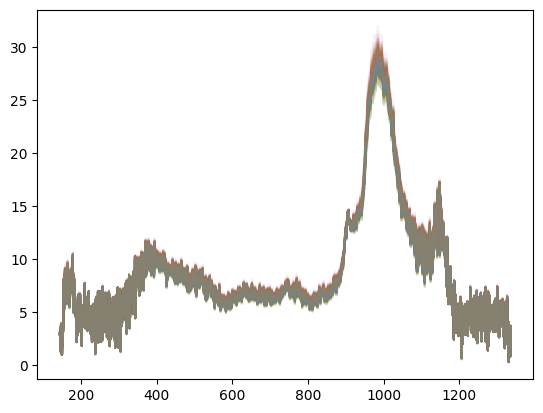

In [ ]:
plt.plot(vis_cols, pred["A @ x_recon"][:, 1, :2048].T, alpha=0.1)

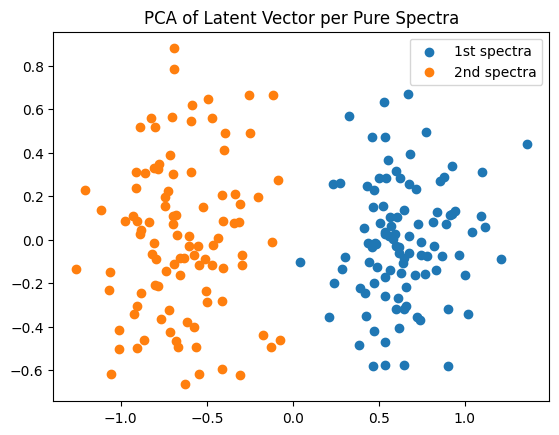

In [ ]:
from sklearn.decomposition import PCA
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
z_loc, z_scale = mcrar_spec.st_regressor.vae.encoder(torch.from_numpy(St.astype(np.float32)))
fst_samples = []
snd_samples = []
for _ in range(100):
    # z = dist.Normal(z_loc, z_scale).sample()
    # sample = mcrar.st_regressor.vae.decoder(z).detach().numpy()
    z = mcrar_spec.st_regressor.guide(St, D)["latent"].detach().numpy()
    # spectra = mcrar.st_regressor.vae.decoder(z)
    # spectra = spectra.detach().numpy()
    fst_samples.append(z[0, :])
    snd_samples.append(z[1, :])
samples = np.vstack((fst_samples, snd_samples))
# print(samples.shape)

pca = PCA(n_components=2)
res = pca.fit_transform(samples)
plt.scatter(res[:len(fst_samples), 0], res[:len(fst_samples), 1], label="1st spectra")
plt.scatter(res[len(fst_samples):, 0], res[len(fst_samples):, 1], label="2nd spectra")
plt.title("PCA of Latent Vector per Pure Spectra")
plt.legend()

epoch loss 265259051.10285342
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 1 (ST)	mse: 1.9086e-02
Iter: 2 (C)	mse: 1.3537e-02
epoch loss 259800348.47320879
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 2 (ST)	mse: 1.1708e-03
Iter: 3 (C)	mse: 1.1293e-03
epoch loss 254412094.32568526
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 3 (ST)	mse: 6.5973e-04
Iter: 4 (C)	mse: 6.4745e-04
epoch loss 248699303.45877647
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 4 (ST)	mse: 1.1119e-03
Iter: 5 (C)	mse: 1.0035e-03
epoch loss 242901664.64345968
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 5 (ST)	mse: 6.1938e-04
Iter: 6 (C)	mse: 5.5774e-04
epoch loss 236819035.21540833
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 6 (ST)	mse: 1.0472e-03
Iter: 7 (C)	mse: 1.1113e-03
epoch loss 231699277.25931102
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 7 (ST)	mse: 1.1692e-03
Iter: 8 (C)	mse: 5.7

(<Figure size 1600x800 with 2 Axes>,
 array([<Axes: title={'center': 'Visible Predicted Pure Spectra'}, xlabel='Wavelength (nm)', ylabel='Predicted Absorbance'>,
        <Axes: title={'center': 'NIR Predicted Pure Spectra'}, xlabel='Wavelength (nm)'>],
       dtype=object))

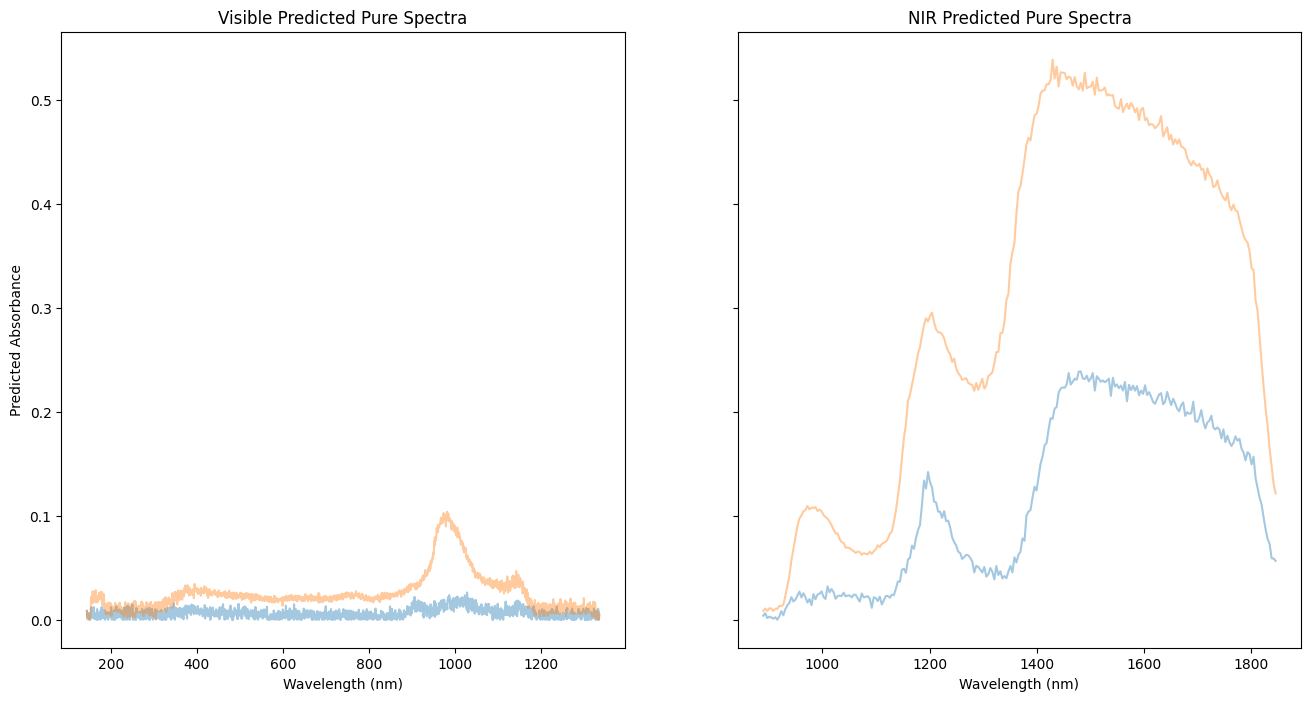

In [ ]:
plot_mcrar_spectra(mcr_obj=McrAR(
    max_iter=100,
    st_regr=McrVae(input_size=N_WAVELENGTHS, hidden_size=16, z_dim=4),
    c_regr="OLS",
    # c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
))

In [ ]:
with open("../../data/241022-mcr-datasets/ethanol/lsq.npz", "rb") as lsq_file:
    lst_output = np.load(lsq_file)
    lsq_res = lst_output["lsq_st"]

Text(0.5, 0, 'Wavelength (nm)')

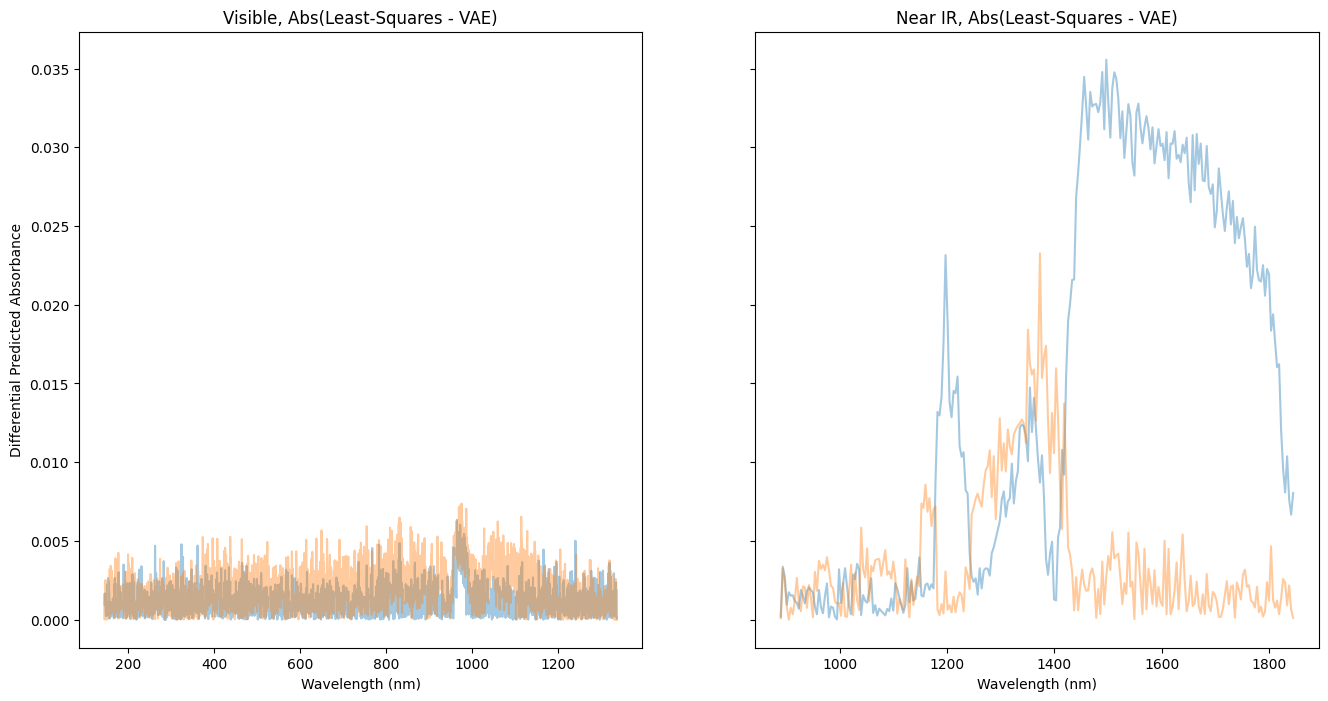

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

ax[0].plot(
    vis_cols,
    abs(mcrar_spec.ST_[0, :2048] - lsq_res[0, :2048]),
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    abs(mcrar_spec.ST_[1, :2048] - lsq_res[1, :2048]),
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    abs(mcrar_spec.ST_[0, 2048:] - lsq_res[0, 2048:]),
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    abs(mcrar_spec.ST_[1, 2048:] - lsq_res[1, 2048:]),
    alpha=0.4,
)

ax[1].set_title("Near IR, Abs(Least-Squares - VAE)")
ax[0].set_title("Visible, Abs(Least-Squares - VAE)")
ax[0].set_ylabel("Differential Predicted Absorbance")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")